# **4: Hands-on Exploratory Data Analysis with DuckDB :duck:**

---

By Jean-Yves Tran | jy.tran@[datascience-jy.com](https://datascience-jy.com) | [LinkedIn](https://www.linkedin.com/in/jytran-datascience/)  
IBM Certified Data Analyst 

---

Source: 
- [Getting Started with DuckDB](https://www.packtpub.com/en-ar/product/getting-started-with-duckdb-9781803232539) by Simon Aubury & Ned Letcher
- [DuckDB documentation](https://duckdb.org/docs/)
---

The interactive links in this notebook are not working due to GitHub limitations. View this notebook with the interactive links working [here](https://nbviewer.org/github/jendives2000/Data_ML_Practice_2025/blob/main/1-3-SQL/practice/DuckDB/notebooks/4_duckdb_handson_eda.ipynb).

---

This is part 4 of this series of notebooks on DuckDB.  
Find the 3 previous notebooks: 
- intro to DuckDB, [notebook 1](https://github.com/jendives2000/Data_ML_Practice_2025/blob/82571ad44176666f9cf0735c5141c6a96d5eace9/1-3-SQL/practice/DuckDB/notebooks/1_duckdb_intro.ipynb).
- how DuckDB works, [notebook 2](https://github.com/jendives2000/Data_ML_Practice_2025/blob/ef8533ad82586234cfdc54a494c0c5be590816cc/1-3-SQL/practice/DuckDB/notebooks/2_duckdb_python_API.ipynb)
- DuckDB best practices, [notebook 3](https://github.com/jendives2000/Data_ML_Practice_2025/blob/ef8533ad82586234cfdc54a494c0c5be590816cc/1-3-SQL/practice/DuckDB/notebooks/3_duckdb_bestpractices.ipynb)

For this notebook, I will:
- first introduce the dataset I will work on
- clean it up
- and explore that data (EDA)
  - including with visualizations (Plotly & Plotly Express)


<u>**Relational API & JupySQL:**</u>  

I use two ways to leverage DuckDB:
- its Relational API, efficient and pythonic 
- and JupySQL, which enables direct SQL queries in a Jupyter notebook cell (with just '%%sql')
  
I will not reintroduce the Relational API, for that check my notebook 1.  
JupySQL needs to be installed (`pip install jupysql`) and imported. I will also show how to enable it. 

**Large File**:  
Be aware that the dataset I will explore weighs 420MB. While this is by no means a heavy dataset, you still need the memory space for it. More about that in the dataset paragraph.

**OUTLINE:**  

**DATABASE & Git LFS**:  
Like I said this dataset weighs 420MB. I will give the link to download it if you prefer that way (you could just clone the [DuckDB folder](https://github.com/jendives2000/Data_ML_Practice_2025/tree/dc1fe3fe414909d0fce9bc18a62a56091e191f4b/1-3-SQL/practice/DuckDB)).  
Note that because of that size, Git LFS was needed to make it available in this repo. So you may have to download the dataset via Git itself, I will not show how. 

**The main takeaway is**:
- to **better comprehend** the **differences** between regular SQL queries and DuckDB enhanced queries, which is often a lot less verbosity and more readability. 

---


## **Imports**:

In [1]:
#! pip install pandas matplotlib
# Add parent directory to sys.path
import sys
import os
sys.path.append(os.path.abspath(".."))

import duckdb
import pandas as pd
from utils.duckdb_shared_code import init_plotly_template
init_plotly_template()

---

## **Dataset: Melbourne Pedestrian Count**:

I will be using a dataset made available by the city of Melbourne, Australia. contains **hourly pedestrian counts** from pedestrian sensors located in and around the Melbourne Central business district. We’ll be working with a historical timeframe of this dataset ranging from **2009 to 2022**.

I [imported](https://data.melbourne.vic.gov.au/api/datasets/1.0/pedestrian-counting-system-monthly-counts-per-hour/attachments/pedestrian_counting_system_monthly_counts_per_hour_may_2009_to_14_dec_2022_csv_zip/) it in the data/data_in folder. 
Once unzipped, this is:
- a **420MB** dataset 
- with over **2,1 million entries**


## **Relational API**: 

I will use the Relational API because it offers more for what I will be doing: data exploratory analysis. 

Let's get our dataset into a Relational Object (RO from now on):

In [2]:
records = duckdb.read_csv("../data/data_in/pedestrian_records_2009-2022.csv")

# 200 is the max number of characters possible inside an entry:
records.show(max_width = 200)

┌─────────┬───────────────────────────────┬───────┬──────────┬───────┬──────────┬───────┬───────────┬───────────────────────────────┬───────────────┐
│   ID    │           Date_Time           │ Year  │  Month   │ Mdate │   Day    │ Time  │ Sensor_ID │          Sensor_Name          │ Hourly_Counts │
│  int64  │            varchar            │ int64 │ varchar  │ int64 │ varchar  │ int64 │   int64   │            varchar            │     int64     │
├─────────┼───────────────────────────────┼───────┼──────────┼───────┼──────────┼───────┼───────────┼───────────────────────────────┼───────────────┤
│ 2887628 │ November 01, 2019 05:00:00 PM │  2019 │ November │     1 │ Friday   │    17 │        34 │ Flinders St-Spark La          │           300 │
│ 2887629 │ November 01, 2019 05:00:00 PM │  2019 │ November │     1 │ Friday   │    17 │        39 │ Alfred Place                  │           604 │
│ 2887630 │ November 01, 2019 05:00:00 PM │  2019 │ November │     1 │ Friday   │    17 │        37 

## **Looking at the Data**:

Because this is an RO, DuckDB loaded 10,000 rows and this what it **lazily returned** us here.  
10,000 rows with 10 columns each makes **100,000 entries** that were lazily output (out of the total 2,1 millions entries). 

Lots of info in this dataset: 
- **count of pedestrians** detected by 
- a specific **sensor** 
- during **each hour**. 
- Additionally, it provides other details related to the hourly readings, including the **sensor name** 
  - and the **timestamp**, along with date and time components derived from the timestamp.

### **Data types**:
Notice in the header of the output that **datetime** is of the data type **VARCHAR**, meaning text. It should be a timestamp (docs on this [here](http://duckdb.org/docs/sql/functions/dateformat)). Let's fix that:

In [3]:
records = duckdb.read_csv(
    "../data/data_in/pedestrian_records_2009-2022.csv",
    dtype={"Date_Time": "TIMESTAMP"},
    timestamp_format="%B %d, %Y %H:%M:%S %p",
)

Let's confirm this change:

In [4]:
records.limit(5).show(max_width=200)

┌─────────┬─────────────────────┬───────┬──────────┬───────┬─────────┬───────┬───────────┬──────────────────────────────┬───────────────┐
│   ID    │      Date_Time      │ Year  │  Month   │ Mdate │   Day   │ Time  │ Sensor_ID │         Sensor_Name          │ Hourly_Counts │
│  int64  │      timestamp      │ int64 │ varchar  │ int64 │ varchar │ int64 │   int64   │           varchar            │     int64     │
├─────────┼─────────────────────┼───────┼──────────┼───────┼─────────┼───────┼───────────┼──────────────────────────────┼───────────────┤
│ 2887628 │ 2019-11-01 17:00:00 │  2019 │ November │     1 │ Friday  │    17 │        34 │ Flinders St-Spark La         │           300 │
│ 2887629 │ 2019-11-01 17:00:00 │  2019 │ November │     1 │ Friday  │    17 │        39 │ Alfred Place                 │           604 │
│ 2887630 │ 2019-11-01 17:00:00 │  2019 │ November │     1 │ Friday  │    17 │        37 │ Lygon St (East)              │           216 │
│ 2887631 │ 2019-11-01 17:00:00 │ 

### **Enums for low cardinality String Columns**:

[ENUM types](https://duckdb.org/docs/sql/data_types/enum.html) are a way to **convert string values into numbers** in a database.  
This is useful for columns with a limited number of different values, like:
- month names 
- and days of the week. 

By using ENUMs for these columns, we can:
- **save storage space** 
- and **speed up queries** 

because the database only stores numbers instead of full strings.  

In DuckDB, because the **SQL parser doesn’t support subqueries** in a CREATE TYPE ... AS ENUM statement, the best approach is to:
- **extract** the distinct values via SQL (or pandas),
- **format** them into a comma-separated list, 
- and then **build** the ENUM type dynamically.  

This method gives me flexibility and control over the ENUM values while keeping my code concise.

In [5]:
# refactored logic to create ENUM with an RO:
def create_enum(col, db, enum_name):
    """
    Create an ENUM type in DuckDB from unique values in a specified column.

    Parameters:
    col (str): The column name to extract unique values from.
    db (str): The name of the DuckDB relation (table).
    enum_name (str): The name of the ENUM type to be created.
    """
    # extracting the unique values from the specified column
    col_forEnum = duckdb.sql(
        f"""
        select distinct {col}
        from {db}
        """
    ).fetchall()

    # Build a comma-separated list of ENUM values
    col_enum_val = ", ".join(f"'{v[0]}'" for v in col_forEnum)

    # create the ENUM type
    duckdb.sql(f"create type {enum_name} as enum ({col_enum_val});")

# creating enums for the Month column:
create_enum("Month", "records", "month_enum")

In [6]:
# creating enums for the Day column:
create_enum("Day", "records", "day_enum")

Did I actually created them? The output says yes!

In [7]:
print(duckdb.sql("select enum_range(NULL::month_enum);"))
print(duckdb.sql("select enum_range(NULL::day_enum);"))

┌────────────────────────────────────────────────────────────────────────────────────────────────────┐
│                                enum_range(CAST(NULL AS month_enum))                                │
│                                             varchar[]                                              │
├────────────────────────────────────────────────────────────────────────────────────────────────────┤
│ [March, October, July, January, June, February, May, November, April, December, September, August] │
└────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌──────────────────────────────────────────────────────────────────┐
│                enum_range(CAST(NULL AS day_enum))                │
│                            varchar[]                             │
├──────────────────────────────────────────────────────────────────┤
│ [Sunday, Thursday, Friday, Saturday, Monday, Wednesday, Tuesday] │
└───────────────────────────────────

### **Selecting useful Columns**:

Before we load our dataset into an on-disk database for analysis, we should think about any data changes we might want to make. 
For instance, we can remove columns we won’t need:  
- the additional date and time fields are likely to be useful, 
- and we should keep the Sensor_ID column since it helps connect this dataset with another one from the city of Melbourne that includes details about each sensor, like their locations.  
- **However**, we can **drop the ID field** because it doesn’t relate to any other datasets about the pedestrian counting system.  
- Since we’ll be doing various time series analyses, we also need to **sort the records by the Date_Time column**.  

Let’s make these changes and take a look at the results.

In [8]:
records_v2 = records.select("* exclude ID").sort("Date_Time")

In [9]:
records_v2.limit(5).show(max_width=200)

┌─────────────────────┬───────┬─────────┬───────┬─────────┬───────┬───────────┬───────────────────────────────────┬───────────────┐
│      Date_Time      │ Year  │  Month  │ Mdate │   Day   │ Time  │ Sensor_ID │            Sensor_Name            │ Hourly_Counts │
│      timestamp      │ int64 │ varchar │ int64 │ varchar │ int64 │   int64   │              varchar              │     int64     │
├─────────────────────┼───────┼─────────┼───────┼─────────┼───────┼───────────┼───────────────────────────────────┼───────────────┤
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         5 │ Princes Bridge                    │           157 │
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         1 │ Bourke Street Mall (North)        │            53 │
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         6 │ Flinders Street Station Underpass │           139 │
│ 2009-05-01 00:00:00 │  2009 │ May     │     1 │ Friday  │     0 │         

All this pre-analysis work is done, the data is good to go.  

## **Advantages of loading into a disk-based database**:
I need to load it into a **persistent** disk-based database so that the whole data is **written and safely saved**, making it **available** for another time or another person. 

This means I will NOT use the default database duckdb anymore. This data I just cleaned up will be in a **table** in the database. That cleaning-up process will **NOT happen again** as it is now 'persistingly' reflected in the new database. 

This has the following advantages: 
- **saves compute time**, especially on large and/or complex datasets
- **separates data loading from data consumption**: 
  - so multiple notebooks can do their own analyses, **consuming** the same database data **without impacting** the data itself.

Now, to encapsulate all of: 
- the cleaning-up I did so far 
- and the table/database creation 
- while ensuring that everything is written off and saved safely 

I am using the context's manager `with` block. I call: 
- the table `pedestrian_counts`, 
- which is held by the database `pedestrian.duckdb`. 


In [10]:
# context manager with block:
with duckdb.connect("../data/data_out/pedestrian.duckdb") as conn:
    # Drop the table if it exists
    conn.execute("DROP TABLE IF EXISTS pedestrian_counts")
    
    result=(
        # repeating the cleaning-up steps:
        conn.read_csv(
            "../data/data_in/pedestrian_records_2009-2022.csv",
            dtype={"Date_Time": "TIMESTAMP"},
            timestamp_format="%B %d, %Y %H:%M:%S %p",
        )
        .select("* exclude ID")
        .sort("Date_Time")
    )
    # copying the whole result into the new table:
    result.to_table("pedestrian_counts")

## EDA: 

I can now start the EDA, however let's first look at some **more tools** I need: 
- **JupySQl**: to conveniently **run SQL queries directly** within Jupyter cells
- **Plotly**: to create any kind of **interactive visualizations**, well integrated with Jupyter

### SQL directly in Jupyter with JupySQL:

To better understand its advantages, I first use the Relational API with the `.sql()` method to:
- count the total number of pedestrians 
- for the _Melbourne Central_ sensor
- for 2022


In [11]:
conn = duckdb.connect("../data/data_out/pedestrian.duckdb")

conn.sql(
    """
    select sum(Hourly_Counts) as Total_Counts
    from pedestrian_counts
    where Year = 2022 and Sensor_Name = 'Melbourne Central'
    """
)

┌──────────────┐
│ Total_Counts │
│    int128    │
├──────────────┤
│      6897406 │
└──────────────┘

So obviously the downsides are:
- use of a python string (doc strings) to introduce SQL
- use of the sql() method too

This is similar to what I used in the previous notebook where I used the DuckDB shell directly but within the Jupyter notebook. 

### **JupySQL Magic SQL**:
Here's what JupySQL brings to the table. I am configuring it to be used with our new database, but first I **have to close the `conn` one**.  
<u>**REMEMBER**</u>, DuckDB does **NOT allow for multiple concurrent connections** to the same database. 

In [12]:
conn.close()

In [13]:
# enabling SQL Magic
%load_ext sql
%sql duckdb:///../data/data_out/pedestrian.duckdb

Connecting to 'duckdb:///../data/data_out/pedestrian.duckdb'

On top of that, I can now configure it to automatically return a pandas dataframe instead of the usual SQL output, and simplify the output: 

In [14]:
%config Sqlmagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Remember the lazy evaluation thing? By doing that autopandas configuration I **lost that lazy eval**. This has **performance impacts**, for me not so much at it is 'only' a 420MB dataset. If you do that on a very much larger dataset, this will show. 

And with that I am ready to type SQL magic:

In [15]:
%%sql
select sum(Hourly_Counts) as Total_Counts
from pedestrian_counts
where Year = 2022 and Sensor_Name = 'Melbourne Central'

Total_Counts
6897406


All right. What about putting all of that in a variable?  

### **`%%sql var <<`: to assign a df in a var**:
Here's how, by using that syntax: 
`%%sql var_name <<`

I am using it now to:
- calculate the total counts
- for each sensor 
- in 2022
- and sorts them in descending order (biggest first)


In [16]:
%%sql sensors_2022_df <<
SELECT Sensor_Name, sum(Hourly_Counts)::BIGINT AS Total_Counts
FROM pedestrian_counts
WHERE Year = 2022
GROUP BY Sensor_Name
ORDER BY Total_Counts DESC

So in the code above: 
- `::BIGINT` turned the sum of hours count **to an integer**, removing any decimal that would have appeared otherwise
  - Why? 
    - Because the sum itself is of data type **HUGEINT** actually (128-bit integer) preventing the numbers from overflowing (being too big)
    - and because pandas does **not support 128-bit** integers, it converts them to float64 (hence the decimal)
  

In [17]:
print(type(sensors_2022_df))

<class 'sql.run.resultset.ResultSet'>


I printed the type of the variable `sensors_2022_df` and it is actually **not a dataframe**.  
The `autopandas = True` config did <u>**not work as expected**</u>.  
  
So I have to do the conversion manually:

In [18]:
# refactoring the code to turn a variable into a pandas dataframe:
def var_to_df(var):
    """
    Convert a SQL result set to a pandas DataFrame.

    Parameters:
    var (sql.run.resultset.ResultSet): The SQL result set to convert.

    Returns:
    pandas.DataFrame: The converted pandas DataFrame.
    """
    return var.DataFrame()

df_sensors_2022 = var_to_df(sensors_2022_df)
print(type(df_sensors_2022))

df_sensors_2022 = var_to_df(sensors_2022_df)
print(type(df_sensors_2022))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


All right, let's look at it:

In [19]:
df_sensors_2022.head(10)

,Sensor_Name,Total_Counts
0,Flinders La-Swanston St (West),10492872
1,Southbank,8737282
2,Melbourne Central,6897406
3,Elizabeth St - Flinders St (East) - New footpath,6511465
4,Princes Bridge,6202149
5,State Library - New,6049385
6,Flinders Street Station Underpass,5772514
7,Melbourne Convention Exhibition Centre,5634531
8,Bourke Street Mall (North),5614610
9,Melbourne Central-Elizabeth St (East),5380759


An I can see the top ten sensors ranked by traffic. 

### **Plotly**

**Plotly** is actually a JavaScript library, which is called to essentially render the vis into a browser page.  
These rendered objects are named **figures**.  

To build figures, I can use:
- Plotly **components** given to me in its Python API
- or another tool given in that same API, **Plotly Express**, to expressly create figures 

Plotly Express is less finicky but more efficient. In general, it is used first and then components are accessed for fine tuning. 
And Plotly Express was designed for dataframes visualizations for pandas and polars.

Just like any other tool, I need to pip install it (already done) and import it. 

In [20]:
import plotly.express as px

Ok, I want to see a bar chart of that dataframe (df from now on) I just created `df_sensors_2022`:

In [21]:
figure = px.bar(
    df_sensors_2022.head(10),
    x="Sensor_Name",
    y="Total_Counts",
    height=900,  # 5 times bigger than the original 500
    title="Over 10M pedestrians in Flinders La Swanton St.: Top 10 sensors by traffic - 2022",
    color="Total_Counts",
    color_continuous_scale=[[0, 'rgb(65,65,65)'], [1, 'rgb(255,255,100)']]  # Medium grey to pale yellow
)

figure.update_layout(
    title_font_size=35,
    title_font_color="white",
    font=dict(size=25, color="white"),
    xaxis_tickangle=-15,
    plot_bgcolor="black",
    paper_bgcolor="black",
    xaxis=dict(tickfont=dict(color='grey')),  # Set x-axis labels to grey
    margin=dict(l=300, b=280)  # Increase left margin to 200
)

# Adjust the y-axis range to ensure the highest bar is fully visible
figure.update_yaxes(range=[0, 12000000])

figure.show()

I **designed** this graphical configuration by **making decisions** about:
- the background color, 
- fonts size and color too, 
- that gradient applied to the bars
  - and how it fades, 
- the x labels colors too 
  - and how they are rotated. 

#### **Plotly Templates**:
In plotly, this whole graphical configuration (which is essentially your figure) can be saved as a **template** and then very simply and quickly used for future figures.  
This keeps your graphs consistent. 

So I saved it as a template in the duckdb_shared_code.py file as a function and imported it in the import parag. This way this style is available throughout this notebook. 

#### **Line Plot**:
I now want to see: 
- number of active sensors
- accross each year
- in a line plot

So here are the steps:
- I call the SQl query first 
- and then I convert the variable holding it into a df 
- and then I plot it with Plotly


In [22]:
%%sql sensors_cnt_years <<
select Year, count(distinct Sensor_Name) as Total_Sensors
from pedestrian_counts
group by Year
order by Year

In [23]:
# converting to a df
df_sensors_cnt_years = var_to_df(sensors_cnt_years)
df_sensors_cnt_years.head(5)

,Year,Total_Sensors
0,2009,18
1,2010,18
2,2011,18
3,2012,18
4,2013,32


Ok, I can now plot it:

In [24]:
year = 2021
total_sensors = 81

figure = px.line(
    df_sensors_cnt_years,
    x="Year",
    y="Total_Sensors",
    markers=True,
    height=700,
    title="Increasing Numbers of Sensors until 2021 - Total Active Sensors by Year",
    line_shape='linear'
)

figure.update_traces(line=dict(color='teal'))

figure.add_annotation(
    x=year,
    y=total_sensors,
    text=f"{year}:\n{total_sensors} sensors",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-20,  # 10px above the point
    font=dict(size=15, color="yellow")
)

figure.update_layout(
    xaxis=dict(
        title="Year",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Total Sensors",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
figure.update_layout(
    width=len(figure.layout.title.text) * 20
)

figure.show()

I used the Plotly **components** for the above graph to customize it: 
- added the graph horizontal lines (or **grid**) and made them a very dark grey
- **pushed** the axis titles from the graph
- and added this **annotation** on the node of the 2021 year

This is following some of the **best practices** when it comes to visualizations.  
Noticed how I phrased the title? Instead of just saying what it is, I say **what is deducted** from it first. 

### **Total Pedestrian Counts over Time**: 

Continuing with this simple EDA and visualizations, I want to better understand how:
- the total number of pedestrians
- captured by all the sensors

has changed over time.

In [25]:
%%sql year_counts <<
select year, sum(Hourly_Counts)::BIGINT as Total_counts
from pedestrian_counts
group by Year
order by Year

In [26]:
df_year_counts = var_to_df(year_counts)
df_year_counts.head(5)

,Year,Total_counts
0,2009,62650110
1,2010,93459437
2,2011,90571965
3,2012,102215521
4,2013,117389820


Here's the Plotly Express code for a line plot of this new df:

In [27]:
px.line(
    df_year_counts,
    x="Year",
    y="Total_counts",
    markers=True,
    height=500,
    title="Total Pedestrian Counts by Year"
)

Let's fine tune this with Plotly components:

In [28]:
year19 = 2019
year16 = 2016
year20 = 2020

figure2 = px.line(
    df_year_counts,
    x="Year",
    y="Total_counts",
    markers=True,
    height=500,
    title="Total Pedestrian Counts by Year"
)

figure2.update_traces(line=dict(color='teal'))

def format_millions(value):
    return f"{value / 1_000_000:.2f}M"

figure2.add_annotation(
    x=year19,
    y=df_year_counts[df_year_counts['Year'] == year19]['Total_counts'].values[0],
    text=f"{year19}:   \n{format_millions(df_year_counts[df_year_counts['Year'] == year19]['Total_counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,  # 10px above the point
    font=dict(size=15, color="yellow")
)

# annotation for year 2016
figure2.add_annotation(
    x=year16,
    y=df_year_counts[df_year_counts['Year'] == year16]['Total_counts'].values[0],
    text=f"{year16}:   \n{format_millions(df_year_counts[df_year_counts['Year'] == year16]['Total_counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=35,  # 10px above the point
    font=dict(size=15, color="yellow")
)

# annotation for year 2020
figure2.add_annotation(
    x=year20,
    y=df_year_counts[df_year_counts['Year'] == year20]['Total_counts'].values[0],
    text=f"{year20}:   \n{format_millions(df_year_counts[df_year_counts['Year'] == year20]['Total_counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=45,  # 10px above the point
    font=dict(size=15, color="yellow")
)

figure2.update_layout(
    xaxis=dict(
        title="Year",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Total Records",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
figure2.update_layout(
    width=len(figure.layout.title.text) * 20
)

figure2.show()

#### **Simple Analysis**:
2020 saw a dramatic drop, which coincides with the **2019 COVID-19 pandemic** and lock down. 
I also know that sensors were added over the years, and that is impacting the 2020 total records too.  

To know more **precisely** by how much that drop in 2020 was, I need to **filter out** all the sensors that **were added**.  
How?  
By selecting the **sensors that have records for all years**, because these sensors were there since the beginning and were not added later on. 

So first I need to know how many years are counted in the dataset. There are 14 distinct years. 
For my need here, this means that:
- each sensor that that was there since the beginning (and so was not added later on) 
- has exactly 14 captured values, one for each year. 

I do not want any other sensor. 

In [29]:
%%sql distinct_years <<
select count(distinct Year)
from pedestrian_counts

In [30]:
print(f"\n{distinct_years}")


+------------------------+
| count(DISTINCT "Year") |
+------------------------+
|           14           |
+------------------------+


### **Specific Sensor_Name**:
It's best to capture these 14-years sensors' values into its own table:

In [31]:
%%sql
create or replace table sensors14years as       -- new table
select Sensor_Name
from pedestrian_counts
group by Sensor_Name                            -- getting only unique sensor names...
having count(distinct Year) = 14                -- ...that each has records on all 14 years 
;

Count


The `GROUP BY Sensor_Name`:   
The selected data is grouped by unique values in the "Sensor_Name" column. This means that **all rows with the same "Sensor_Name**" will be grouped together in that column.

`HAVING COUNT(DISTINCT Year) = 14`:  
The `HAVING` clause is used to filter the result of the grouping, which is the unique sensor names in the Sensor_Name column. From all these unique sensors, it's **looking for ones that do have 14 distinct "Year" values**.  
If I used a WHERE clause instead, it would have looked at the rows before grouping the relevant sensor names. 

Another query tells us there are **15 such sensors**. Their name is in the table `sensors14years`. 

In [32]:
%%sql 
select count(Sensor_Name)
from sensors14years

count(Sensor_Name)
15


Now that I know the sensors I need, I can use it to filter out the total count of records and see how that 2020 year changes. 

In [33]:
%%sql year_counts_15sensors <<
select
    Year,
    sum(Hourly_Counts)::BIGINT as Total_Counts      -- sum of records converted to 64-bits integer
from pedestrian_counts
where Sensor_name in (from sensors14years)          -- ensuring to ONLY get sensors from sensors14years
group by Year                                       -- returning sum of records for each year
order by Year

In [34]:
df_year_counts_15sensors = var_to_df(year_counts_15sensors)
df_year_counts_15sensors.head(5)

,Year,Total_Counts
0,2009,50221628
1,2010,75078494
2,2011,71806437
3,2012,83356740
4,2013,81092589


#### Updated Line Plot:
And I am now back at the line plot, updating it with this new data based on the relevant sensors:

In [35]:
year19 = 2019
year16 = 2016
year20 = 2020

figure2 = px.line(
    df_year_counts_15sensors,
    x="Year",
    y="Total_Counts",
    markers=True,
    height=500,
    title="Increasing Pedestrian Counts until Covid-19 - Total Pedestrian Counts by Year"
)

figure2.update_traces(line=dict(color='white'))

def format_millions(value):
    return f"{value / 1_000_000:.2f}M"

figure2.add_annotation(
    x=year19,
    y=df_year_counts_15sensors[df_year_counts['Year'] == year19]['Total_Counts'].values[0],
    text=f"{year19}:   \n{format_millions(df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year19]['Total_Counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=-30,
    font=dict(size=15, color="yellow")
)

# annotation for year 2016
figure2.add_annotation(
    x=year16,
    y=df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year16]['Total_Counts'].values[0],
    text=f"{year16}:   \n{format_millions(df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year16]['Total_Counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=35,
    font=dict(size=15, color="yellow")
)

# annotation for year 2020
figure2.add_annotation(
    x=year20,
    y=df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year20]['Total_Counts'].values[0],
    text=f"{year20}:   \n{format_millions(df_year_counts_15sensors[df_year_counts_15sensors['Year'] == year20]['Total_Counts'].values[0])}",
    showarrow=True,
    arrowhead=2,
    ax=0,
    ay=45,
    font=dict(size=15, color="yellow")
)

figure2.update_layout(
    xaxis=dict(
        title="Year",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Total Records",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)

# Dynamically adjust the width based on the title length
figure2.update_layout(
    width=len(figure.layout.title.text) * 20,
    height=700
)

figure2.show()

As expected. Because there are less sensors and most of all, NO sensors added over the years, the increase each year is diminished, and the COVID-19 drop is even more dramatic. 

### **Zoom in on 2019 to 202**1:
I now want to zoom in on these years 2019 to 2021 so that I can see numbers per month. 

I will extract the data accordingly from the `pedestrian_count` table. Here's what I need:
- years and months
- total counts for each
- from the 15 sensors (`df_year_counts_15sensors`)

In [36]:
%%sql yr_mths_counts <<
select
    Year,
    Month,                                          -- selecting the actual months...
    month(Date_Time) as Month_Num,                  -- ...adding the corresponding month number... 
    sum(Hourly_Counts)::BIGINT as Total_Counts
from pedestrian_counts
where Year in (2019, 2020, 2021)                    -- ...from these 3 years only...
    and Sensor_Name in (from sensors14years)        -- ...and these sensors only...
group by 
    Year, Month, Month_Num                          -- and returning Total_Counts for Year, Month
order by
    Year, Month_Num

Before I convert this to a df, note that the line 5:
- `month(Date_Time) as Month_Num,`
is adding the corresponding month number into a new column `Month_Num` by using a DuckDB function, `month()`. 

Also, I had to add it to the group by clause, however it is not messing with the grouping because Month_Num values are coming from Month. But it wasn't, then yes, it would have been messing with the grouping. 

In [37]:
df_yrs_mths_counts = var_to_df(yr_mths_counts)
df_yrs_mths_counts.head(15)

,Year,Month,Month_Num,Total_Counts
0,2019,January,1,7000243
1,2019,February,2,6079776
2,2019,March,3,7740551
3,2019,April,4,8281383
4,2019,May,5,7908534
5,2019,June,6,7323166
6,2019,July,7,7915558
7,2019,August,8,8013224
8,2019,September,9,7436127
9,2019,October,10,7665717


#### **Multiple Lines with Plotly Traces**: 
This df is ready for plotting. I want to see each year plotted as **its own line**.  
In Plotly Express I can do that by referencing them as **traces** and other parameters of the plot. 

Note that I also chose to make the line in both a different **color** and a different **marker**, to make each line demarks itself better. 

In [38]:
from plotly.subplots import make_subplots

# Create subplots: 1 row, 3 columns with reduced spacing
fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=("2019", "2020", "2021"), horizontal_spacing=0.01)

# Add traces for each year
years = [2019, 2020, 2021]
symbols = ["square", "diamond", "circle"]
colors = ["#1F77B4", "#FF7F0E", "#2CA02C"]

for i, year in enumerate(years):
    df_year = df_yrs_mths_counts[df_yrs_mths_counts["Year"] == year]
    fig.add_trace(
        px.line(
            df_year,
            x="Month",
            y="Total_Counts",
            markers=True,
            symbol_sequence=[symbols[i]],
            color_discrete_sequence=[colors[i]]
        ).data[0],
        row=1, col=i+1
    )

# Update layout
fig.update_traces(marker=dict(size=12))  # Increase marker size

fig.update_layout(
    height=500,
    title="Post COVID-19: 2019, 2020, 2021 monthly Traffic - 15 original sensors",
    title_font_color="white",
    showlegend=False
)

fig.update_xaxes(title_text="Months", title_standoff=50, automargin=True, tickfont=dict(color='rgb(90,90,90)'))
fig.update_yaxes(title_text="Total Records", title_standoff=50, automargin=True, gridcolor='rgb(45,45,45)', range=[0, 10_000_000])

# Remove y-axis title for the 2nd and 3rd subplots
fig.update_yaxes(title_text=None, row=1, col=2)
fig.update_yaxes(title_text=None, row=1, col=3)

fig.show()


For continuity I chose to plot these 3 years side by side, clearly showing the decline progressing from 2019.  
Keep in mind that the data was applying the df with ONLY the 15 original sensors (no new ones added), giving us more refined counts. 


### Zoom in on Hours data:

As I zoomed in into the months of these 3 years, I now want to look at:
- hours 
- of specific sensors

This Flinders La-Swanston St (West) sensor is the one that collected the highest number of records (go back to the [plot here](#plotly)).  
So I want to look at it first.


In [39]:
%%sql sensors_2020 <<
select 
    Hourly_Counts, 
    Date_Time
from pedestrian_counts
where Sensor_Name = 'Flinders La-Swanston St (West)' and Year = 2020 

In [40]:
sensors_2020_df = var_to_df(sensors_2020)
sensors_2020_df.head(5)

,Hourly_Counts,Date_Time
0,3889,2020-01-01 00:00:00
1,3950,2020-01-01 01:00:00
2,2681,2020-01-01 02:00:00
3,1572,2020-01-01 03:00:00
4,728,2020-01-01 04:00:00


In [52]:
# Plotting a line graph of the new df:

figure = px.line(
    sensors_2020_df,
    y="Hourly_Counts",
    x="Date_Time",
    markers=True,
    height=500,
    width=500,
    title="Drop in Hourly Traffic for Flinders La-Swanton during COVID-19 2020"
)

figure.update_traces(line=dict(color='white'))

figure.update_layout(
    xaxis=dict(
        title="Each single day of 2020",
        title_standoff=50,
        automargin=True  # Ensures Plotly adjusts space automatically
    ),
    yaxis=dict(
        title="Hourly Records",
        title_standoff=50,
        automargin=True  # Prevents overlap issues
    ),
    # Extra space for better visibility
    yaxis_showgrid=True,
    yaxis_gridcolor='rgb(45,45,45)'  # Almost Black
)


# Dynamically adjust the width based on the title length
min_width = 1200
title_length_based_width = len(figure.layout.title.text) * 20
figure.update_layout(
    width=max(title_length_based_width, min_width),
    height=700
)

figure.show()

This graph shows how the traffic evolved in 2020 at the hour detail. Essentially we see:
- three drops, 
  - each corresponding to the first 2 lockdowns:
    - March 31, July 7
Similarly, lift-offs are corresponding to when lockdowns ended:
    - mid-May and October

See that peak on June 6?  
It is coinciding with a Black Lives Matter protest that occurred close to the central business district.



#### Interactive Plot:

As mentioned before, Plotly is interactive, this means that with my mouse cursor I can click and select an area of the plot above, say an area that frame that June 6th day. This will limit the graph to that selection, showing me numbers related to days that are included in the area I chose. Try it now! 

What is striking is that **each day** does not appear as one vertical stick but more like a a row of **wavelengths**, very similar to frequency waves.  
Essentially, each wave represents the **daily rhythm of people's activity**.  
On the 6th of June, if I hover over its points, I can see that starting at 12pm (which seems to be the average peak of most other days, and thinking this way is actually wrong, more below), the traffic kept increasing, reaching almost 4,000 counts at 4pm.  

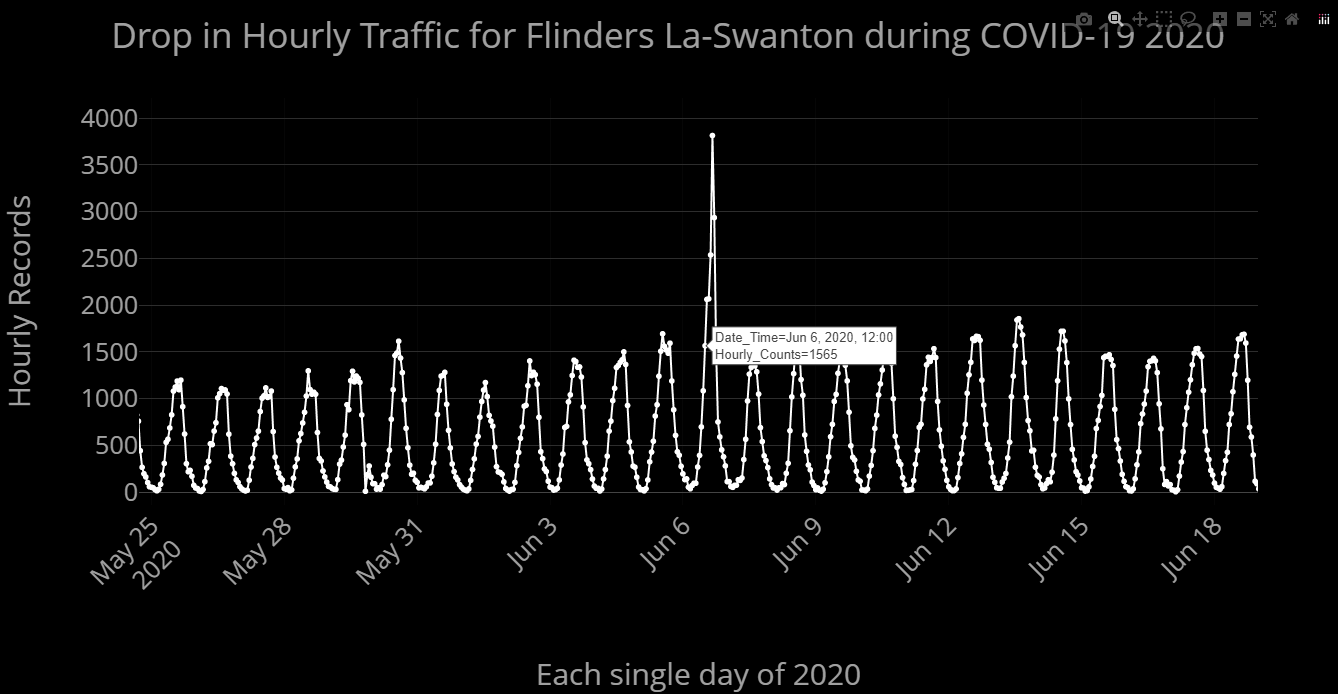

#### Zooming in for more details:
And if I select a range of two days before and after June 6, I see even more details:  

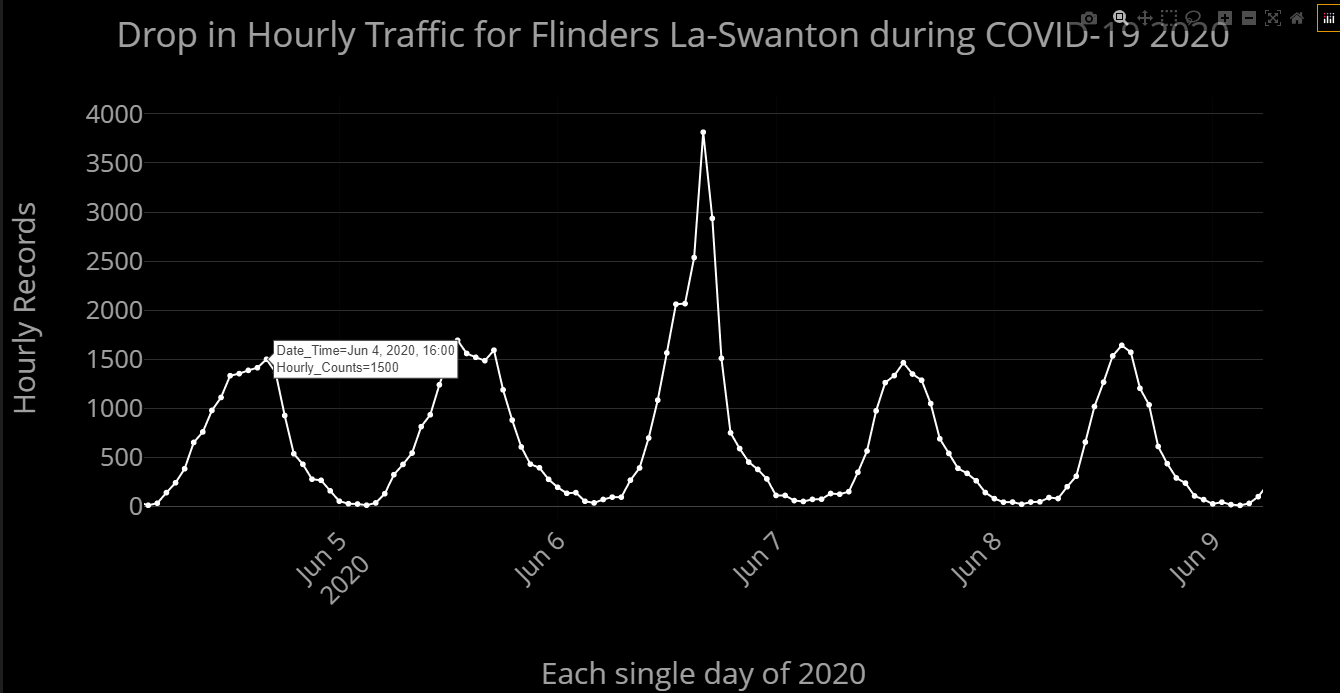

Now I clearly see a 1pm break on June 6, and except for June 4, the peak of each day is between 1 and 2pm.  
This last observation reminds me that the peaks are not on an hour scale (the **y axis is Hourly Records**, **NOT Hour of the day**), and I should not make the mistake of thinking so. These peaks are hourly traffic peaks, and so each peak may be on a different hour, as it is obviously for June 6.

### **Comparing Data Patterns**:

Now my chain of thought is to see if other sensors have this same pattern of daily rhythm.  

So what I want is:
- to compare them and see if there are differences between, say 3 sensors, 
  - for the month of September 
  - year 2019

In [57]:
%%sql three_sensors_sept2019 <<
select 
    Sensor_Name, 
    Hourly_COunts,
    Date_Time
from pedestrian_counts
where Sensor_Name in (                  -- tuple of the 3 sensors names
    'Flinders St-Spark La',
    'Bourke Street Mall (North)',
    'Southern Cross Station',
) and                                   -- filtering down to September 2019
    Year = 2019 and Month = 'September'

In [58]:
df_three_sensors_sept2019 = var_to_df(three_sensors_sept2019)
df_three_sensors_sept2019.Sensor_Name.value_counts()

Sensor_Name
Flinders St-Spark La          720
Bourke Street Mall (North)    720
Southern Cross Station        720
Name: count, dtype: int64

In [87]:
figure = px.line(
    df_three_sensors_sept2019,
    y="Hourly_Counts",
    x='Date_Time',
    facet_col="Sensor_Name",
    facet_col_wrap=1,
    title="Distinct Hourly Traffic Patterns of 3 sensors in Sept. 2019 COVID-19",
    height=800,
).update_layout(yaxis_fixedrange=True)

figure.update_traces(line=dict(color='white'))

# Dynamically adjust the width based on the title length
min_width = 1200
title_length_based_width = len(figure.layout.title.text) * 20
figure.update_layout(
    width=max(title_length_based_width, min_width),
    title_font_color="white",
    height=700
)

# Add horizontal padding and change y-axis label titles
figure.update_yaxes(title_text='Hrly Rec.', automargin=True, title_standoff=60)
figure.update_xaxes(automargin=True, title_standoff=40)
figure.layout.xaxis.title.text = 'Each Day of Sept. 2019'

figure.show()
